In [40]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import nengo_spa
import sspspace
import time
from uniform_encoders import *
palette = sns.color_palette("tab10")
sns.set_palette(palette)
sns.set(context='paper', style='white')

In [47]:
def train_test_subject(
    seed,
    P=2,  # trial time
    pt=1,  # presentation time
    nT=600,  # total trials
    nE=500,  # training trials
    ssp_dim = 64,
    length_scale = 10,
    state_neurons = 300,
    memory_neurons = 300,
    error_neurons = 300,
    feedback_synapse = 0.1,
    learning_rate = 5e-5,
    sigma_target = 1e-1,
    state_type='spa_identity',
    memory_type='spa_identity',
    plot=False
):

    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)

    T = nT*P  # total time
    E = nE*P  # training time

    # Initialize SSP space
    ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
    ssp_space.update_lengthscale([length_scale, length_scale, length_scale])
    
    # dynamic input to the network
    value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
    objects = []
    values = []
    noises = []
    for trial in range(int(T/P)):
        features = rng.uniform(-1,1,size=3)
        object_ssp = ssp_space.encode(features)
        objects.append(object_ssp)
        value = value_func(features)
        values.append(value)
        noise = rng.uniform(0, sigma_target)
        noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    
    # dynamic input to the network
    input_func = lambda t: objects[int(t/P)].flatten() if t%P<pt else np.zeros((ssp_dim))
    target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]
    present_func = lambda t: 0 if t%P<pt else -1000
    feedback_func = lambda t: -1000 if t%P<pt else 0
    test_func = lambda t: 0 if t<E else -1000
    
    # error-driven learning rule
    pes = nengo.PES(learning_rate=learning_rate)
    
    network = nengo.Network(seed=seed)
    with network:
        # network inputs
        inpt_ssp = nengo.Node(input_func)
        inpt_target = nengo.Node(target_func)
        inpt_present = nengo.Node(present_func)
        inpt_feedback = nengo.Node(feedback_func)
        inpt_test = nengo.Node(test_func)

        # state and memory neurons
        if state_type in ['spa', 'spa_identity']:
            cc = True if state_type=='spa_identity' else False
            state = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=state_neurons, represent_cc_identity=cc, seed=seed)
            diff = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=state_neurons, represent_cc_identity=cc, seed=seed+1)
            recall = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=state_neurons, represent_cc_identity=cc, seed=seed+2)
            diff_neuron_inpt = diff.state_ensembles.add_neuron_input()
            recall_neuron_inpt = recall.state_ensembles.add_neuron_input()
        elif state_type == 'ensemble':
            evals = nengo.dists.CosineSimilarity(ssp_dim + 2)
            state = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed, eval_points=evals, intercepts=evals)
            diff = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed+1, eval_points=evals, intercepts=evals)
            recall = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed+2, eval_points=evals, intercepts=evals)
        if memory_type in ['spa', 'spa_identity']:
            cc = True if memory_type=='spa_identity' else False
            memory = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=memory_neurons,
                                     feedback=1.0, feedback_synapse=feedback_synapse, represent_cc_identity=cc, seed=seed+4)
        elif memory_type == 'ensemble':
            evals = nengo.dists.CosineSimilarity(ssp_dim + 2)
            memory = nengo.Ensemble(n_neurons=memory_neurons, dimensions=ssp_dim, seed=seed, eval_points=evals, intercepts=evals)

        # pass through nodes
        output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
        temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
        reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())

        # connect state and memory, via intermediary populations diff (state to memory) and recall (memory to state)
        if state_type in ['spa', 'spa_identity']:
            state_in = state.input
            state_out = state.output
            diff_in = diff.input
            diff_out = diff.output
            recall_in = recall.input
            recall_out = recall.output
        elif state_type=='ensemble':
            state_in = state
            state_out = state
            diff_in = diff
            diff_out = diff
            recall_in = recall
            recall_out = recall
        if memory_type in ['spa', 'spa_identity']:
            memory_in = memory.input
            memory_out = memory.output
        elif memory_type=='ensemble':
            memory_in = memory
            memory_out = memory
        nengo.Connection(inpt_ssp, state_in, synapse=None)
        nengo.Connection(state_out, diff_in, synapse=0.01)
        nengo.Connection(diff_out, memory_in, synapse=feedback_synapse)
        nengo.Connection(memory_out, diff_in, synapse=0.01, transform=-1)
        nengo.Connection(memory_out, recall_in, synapse=0.01)
        nengo.Connection(recall_out, state_in, synapse=0.01)
        pres = []
        conns = []
        if state_type=='spa_identity':
            pres.append(state.state_ensembles.first)
            pres.append(state.state_ensembles.second)
            pres.extend(state.state_ensembles.remainder.ea_ensembles)
        elif state_type=='spa':
            pres.extend(state.state_ensembles.ea_ensembles)
        elif state_type=='ensemble':
            pres.append(state)
        for pre in pres:
            conns.append(nengo.Connection(pre, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
        for conn in conns:
            nengo.Connection(error, conn.learning_rule, synapse=None, transform=-1)
        if memory_type=='ensemble':
            nengo.Connection(memory, memory, synapse=feedback_synapse)

        # connect passthrough nodes
        nengo.Connection(inpt_target, target, synapse=0.01)
        nengo.Connection(output, error, synapse=None, transform=-1)
        nengo.Connection(target, error, synapse=None, transform=1)
        nengo.Connection(output, temp[0], synapse=None)
        nengo.Connection(target, temp[1], synapse=None)
        nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

        # inhibit transmission from state to memory (or visa versa) by inhibiting diff (recall) during feedback (presentation) phase
        if state_type in ['spa', 'spa_identity']:
            nengo.Connection(inpt_present, diff_neuron_inpt, synapse=None, transform=np.ones((diff_neuron_inpt.size_in, 1)))
            nengo.Connection(inpt_feedback, recall_neuron_inpt, synapse=None, transform=np.ones((recall_neuron_inpt.size_in, 1)))
        elif state_type=='ensemble':
            nengo.Connection(inpt_present, diff.neurons, synapse=None, transform=np.ones((state_neurons, 1)))
            nengo.Connection(inpt_feedback, recall.neurons, synapse=None, transform=np.ones((state_neurons, 1)))
        nengo.Connection(inpt_feedback, error.neurons, synapse=None, transform=np.ones((error_neurons, 1)))
        nengo.Connection(inpt_test, error.neurons, synapse=None, transform=np.ones((error_neurons, 1)))

        # collect simulation data
        p_state = nengo.Probe(state_out, synapse=0.01)
        p_memory = nengo.Probe(memory_out, synapse=feedback_synapse)
        p_recall = nengo.Probe(recall_out, synapse=0.01)
        p_diff = nengo.Probe(diff_out, synapse=0.01)
        p_ssp = nengo.Probe(inpt_ssp, synapse=None)
        p_output = nengo.Probe(output, synapse=None)
        p_target = nengo.Probe(target, synapse=None)
        p_error = nengo.Probe(error, synapse=0.01)
        p_reward = nengo.Probe(reward, synapse=None)

    s = time.time()
    sim = nengo.Simulator(network, progress_bar=False)
    with sim:
        sim.run(T-0.001)
    e = time.time()
    # print(f"runtime: {(e-s)/60:.3} minutes")

    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(10,4))
        axes[0].plot(sim.trange(), sim.data[p_ssp])
        axes[1].plot(sim.trange(), sim.data[p_state])
        axes[2].plot(sim.trange(), sim.data[p_memory])
        axes[3].plot(sim.trange(), sim.data[p_recall])
        axes[4].plot(sim.trange(), sim.data[p_diff])
        axes[0].set(title='input')
        axes[1].set(title='state')
        axes[2].set(title='memory')
        axes[3].set(title='recall')
        axes[4].set(title='diff')
        plt.tight_layout()
        # plt.show()

        fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
        axes[0].plot(sim.trange(), sim.data[p_target], label='target')
        axes[0].plot(sim.trange(), sim.data[p_output], label='output')
        axes[1].plot(sim.trange(), sim.data[p_target], label='target')
        axes[1].plot(sim.trange(), sim.data[p_output], label='output')
        axes[2].plot(sim.trange(), sim.data[p_error], label='error')
        axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
        axes[1].axvline(E, color=palette[2], linestyle='--')
        axes[2].axvline(E, color=palette[2], linestyle='--')
        axes[0].set(title='output (early training)', xlim=[0, min([30*P, nT])])
        axes[1].set(title='output (late training)', xlim=[max([0,E-30*P]),min([T, E+30*P])])
        axes[2].set(title='error (testing)', xlim=[max([0,E-20*P]),min([T, E+30*P])])
        axes[0].legend()
        axes[1].legend()
        axes[2].legend()
        sns.despine()
        plt.tight_layout()

    dfs = []
    columns = ['subject', 'error', 'trial', 'phase']
    for trial in range(nE):  # training 
        t_record = int((trial*P+pt/2)/0.001)
        error = sim.data[p_reward][t_record][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'train']], columns=columns))
    for trial in range(nE, nT):  # testing
        t_record = int((trial*P+pt/2)/0.001)
        error = sim.data[p_reward][t_record][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'test']], columns=columns))

    data = pd.concat(dfs, ignore_index=True)
    return data

## Compare ensemble types

runtime: 0.322 minutes


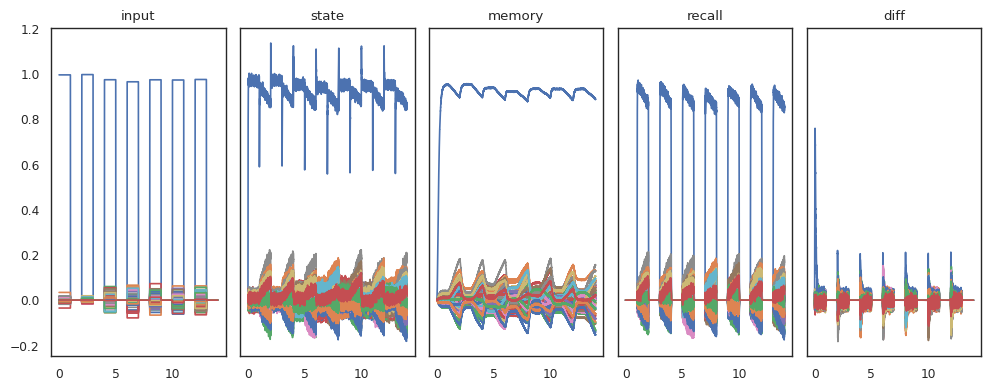

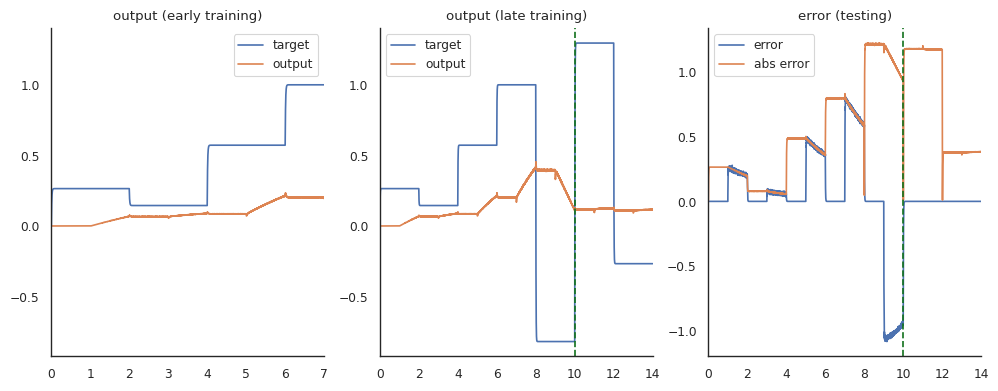

In [14]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='ensemble', memory_type='ensemble',
                          state_neurons=3000, memory_neurons=3000)

runtime: 0.379 minutes


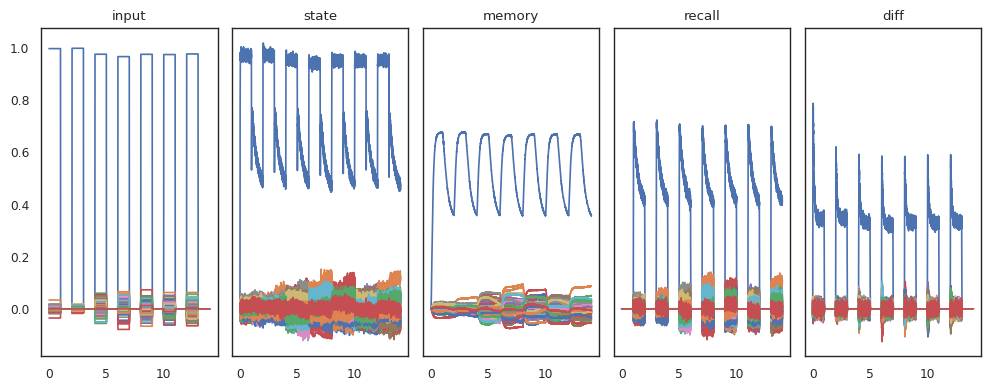

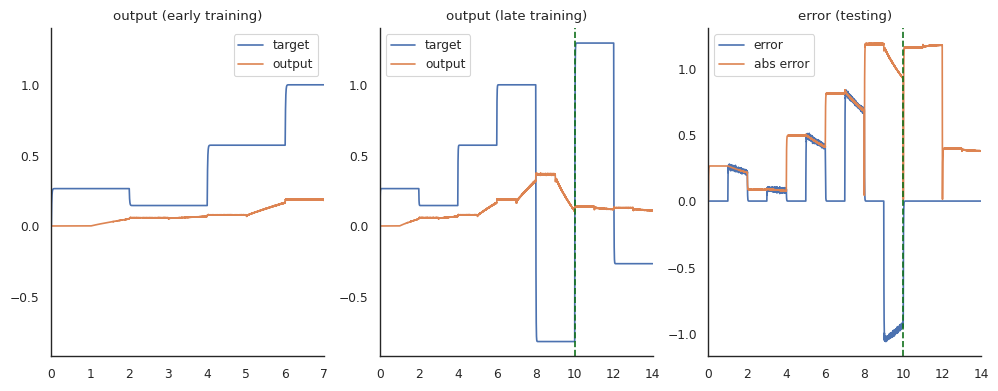

In [17]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='ensemble', memory_type='spa',
                          state_neurons=3000, memory_neurons=300)

runtime: 0.351 minutes


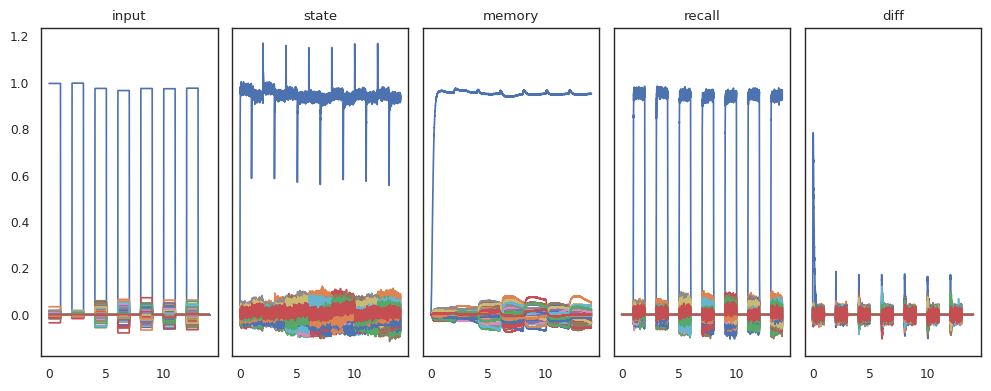

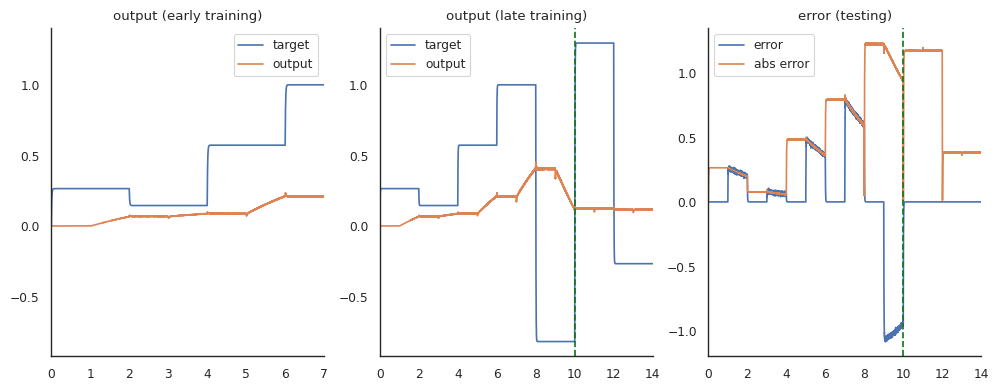

In [18]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='ensemble', memory_type='spa_identity',
                          state_neurons=3000, memory_neurons=300)

runtime: 0.653 minutes


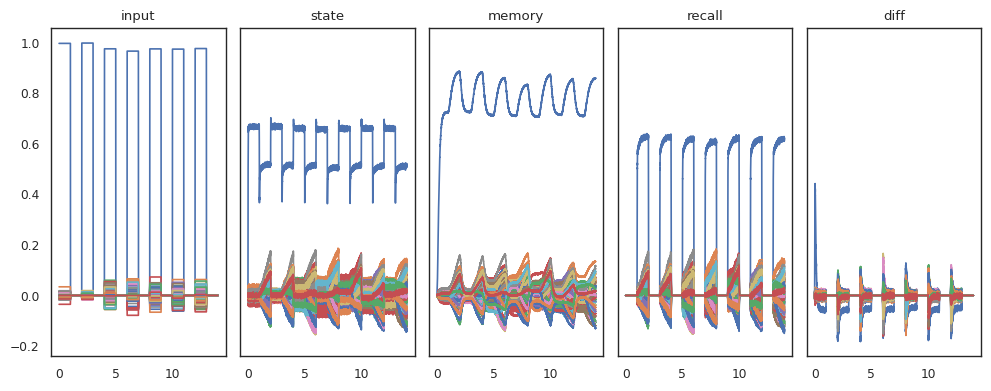

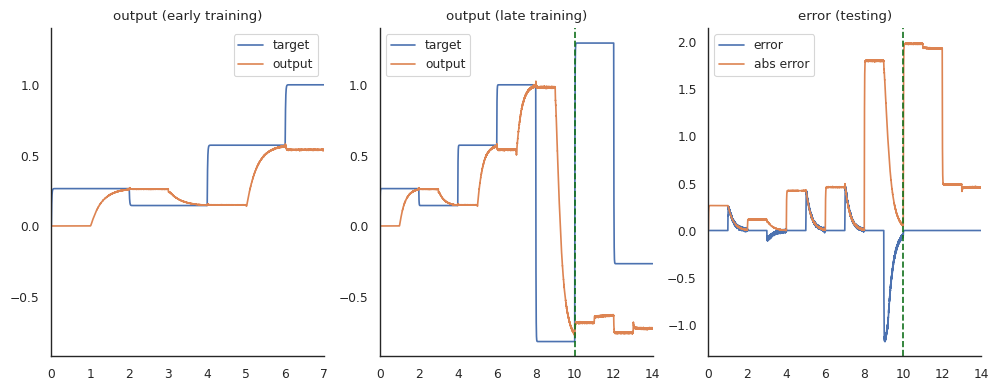

In [23]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='spa', memory_type='ensemble',
                          state_neurons=300, memory_neurons=3000)

runtime: 0.671 minutes


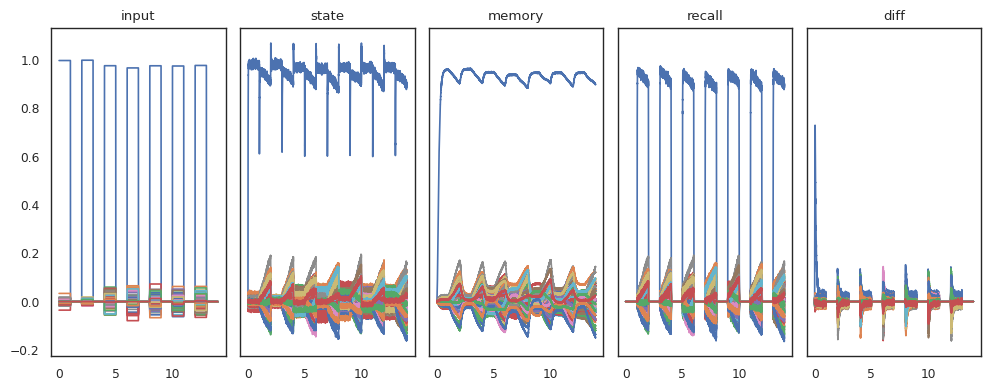

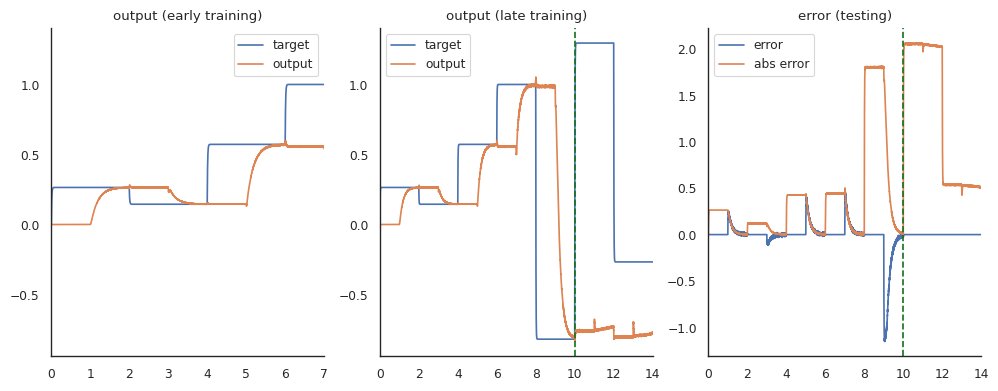

In [24]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='spa_identity', memory_type='ensemble',
                          state_neurons=300, memory_neurons=3000)

runtime: 0.465 minutes


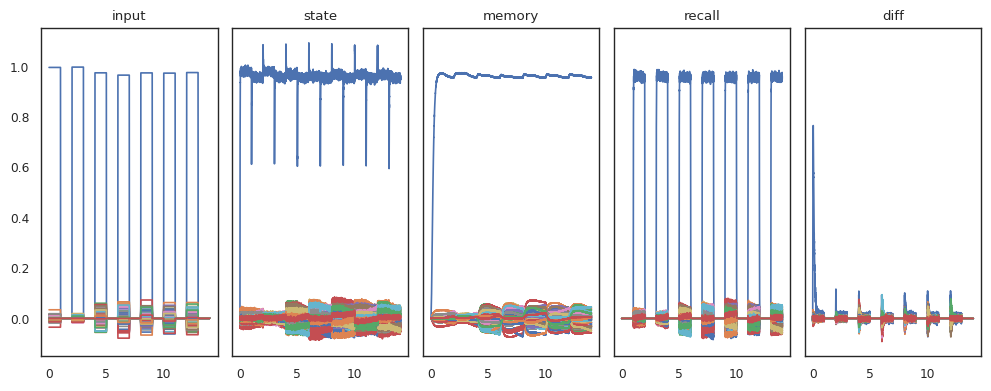

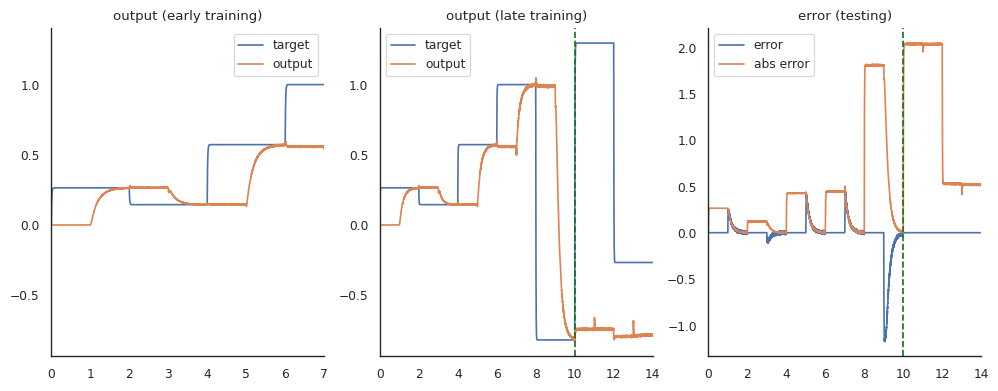

In [25]:
data = train_test_subject(seed=0, plot=True, nE=5, nT=7,
                          state_type='spa_identity', memory_type='spa_identity',
                          state_neurons=300, memory_neurons=300)

runtime: 43.4 minutes


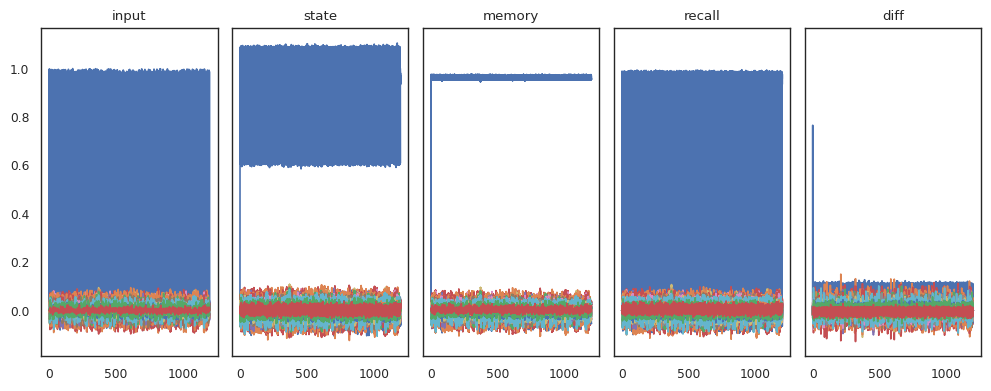

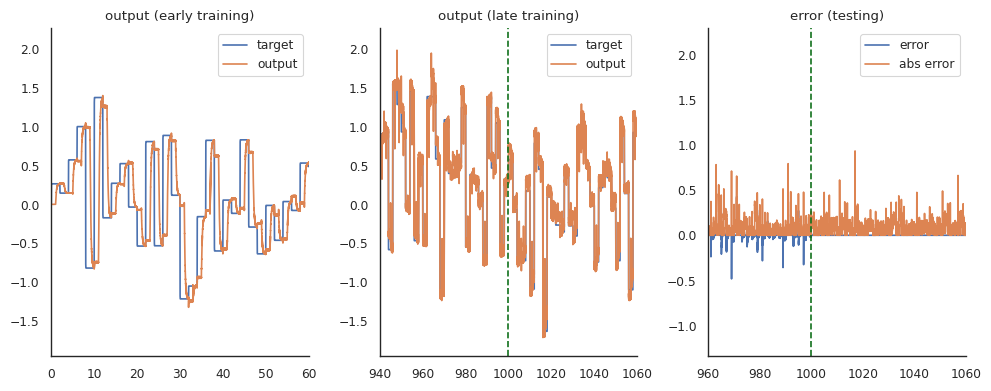

In [26]:
data = train_test_subject(seed=0, plot=True, nE=500, nT=600,
                          state_type='spa_identity', memory_type='spa_identity',
                          state_neurons=300, memory_neurons=300)

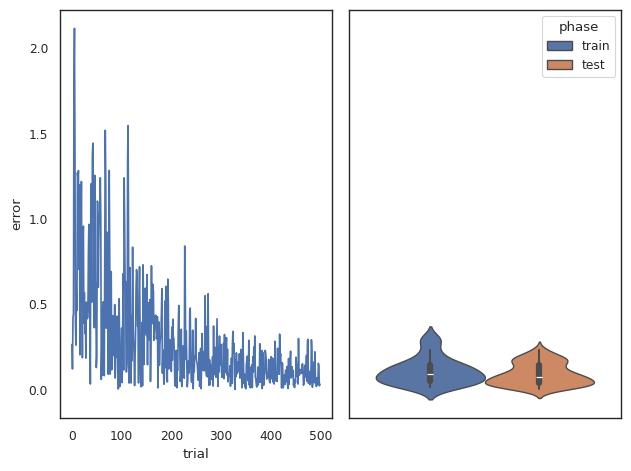

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
sns.lineplot(data.query("phase=='train'"), x='trial', y='error', ax=axes[0])
sns.violinplot(data.query("trial>450"), y='error', hue='phase', ax=axes[1])
plt.tight_layout()

## Test average performance

In [51]:
def run_and_plot_subjects(subjects, **kwargs):
    dfs = []
    s = time.time()
    for seed in range(subjects):
        print(f'training subject {seed}')
        dfs.append(train_test_subject(seed=seed, **kwargs))
    data = pd.concat(dfs, ignore_index=True)
    e = time.time()
    print(f"runtime: {(e-s)/60:.2} minutes")

    training_trials = data.query("phase=='train'")['trial'].to_numpy()
    training_end = training_trials[int(len(training_trials)*0.9)]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3))
    sns.lineplot(data.query("phase=='train'"), x='trial', y='error', ax=axes[0], color=palette[0])
    sns.violinplot(data.query("trial>@training_end"),  y='error', hue='phase', ax=axes[1], palette=palette[:2])
    # sns.boxplot(data.query("phase=='test'"),  y='error', ax=axes[1])
    # sns.barplot(data.query("phase=='test'"),  y='error', ax=axes[1], label=f'mean error: {mean_error:.3}')
    axes[0].set(title='training')
    axes[1].set(title='testing')

    mean_train_error_end = data.query("trial>@training_end & phase=='train'")['error'].mean()
    mean_test_error = data.query("phase=='test'")['error'].mean()
    print(f"final training error: {mean_train_error_end:.3}")
    print(f"final testing error: {mean_test_error:.3}")

training subject 0
runtime: 4.1e+01 minutes
final training error: 0.0845
final testing error: 0.105


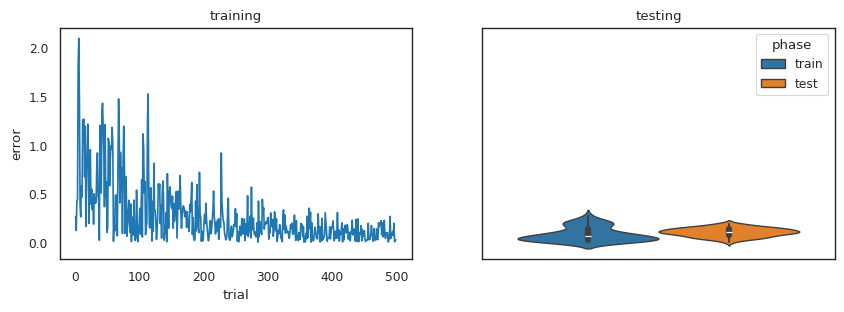

In [57]:
run_and_plot_subjects(subjects=1, nE=500, nT=600, state_neurons=200, memory_neurons=200, learning_rate=5e-5)

training subject 0
runtime: 1.2e+01 minutes
final training error: 0.221
final testing error: 0.151


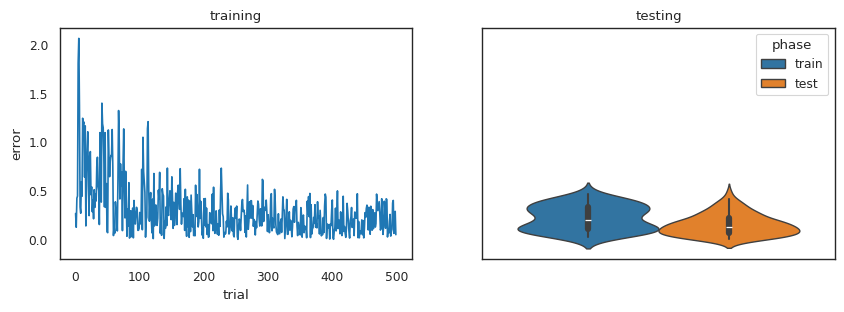

In [58]:
run_and_plot_subjects(subjects=1, nE=500, nT=600, state_neurons=100, memory_neurons=100, learning_rate=5e-5)

training subject 0
runtime: 1.2e+01 minutes
final training error: 0.175
final testing error: 0.116


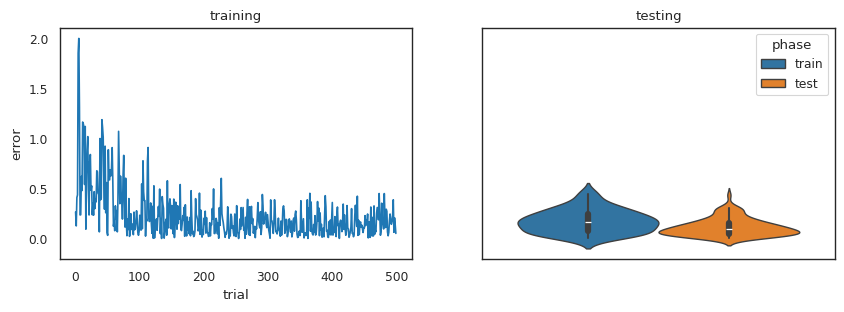

In [59]:
run_and_plot_subjects(subjects=1, nE=500, nT=600, state_neurons=100, memory_neurons=100, learning_rate=5e-5,
                      state_type='spa', memory_type='spa')

training subject 0
training subject 1
runtime: 2e+01 minutes
final training error: 0.154
final testing error: 0.162


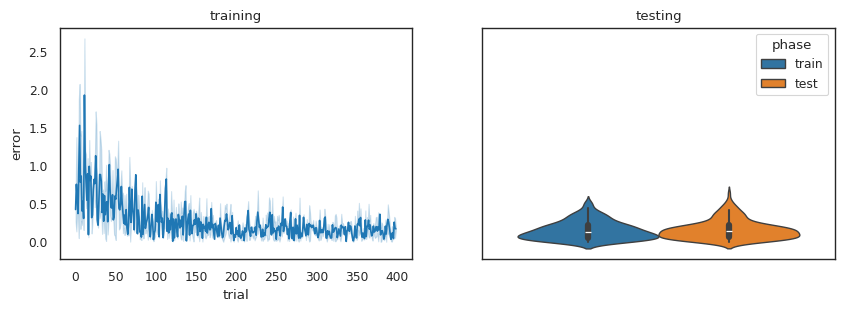

In [60]:
run_and_plot_subjects(subjects=2, nE=400, nT=500, state_neurons=100, memory_neurons=100, learning_rate=1e-4,
                      state_type='spa', memory_type='spa')